In [294]:
import dianna
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import onnxruntime as ort

In [295]:
transform = transforms.Compose([torchvision.transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [296]:
model_path = "./models/mnist_model.onnx" # an onnx model containing a cNN for the binary-mnist, aka. classifying as 0 or 1
axis_labels = {0: 'channels'}

In [297]:
return_training_tensors_from_target_class = lambda target: trainset.data[trainset.targets == target]

In [298]:
first_zero = return_training_tensors_from_target_class(0)[0]

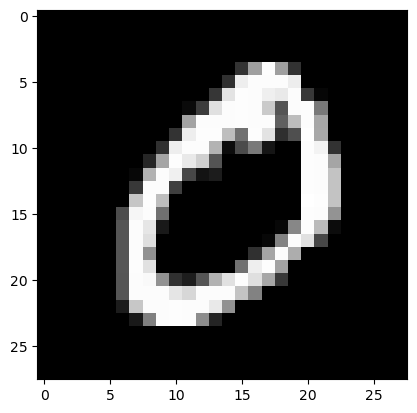

In [299]:
# Display the first zero as reference
plt.imshow(first_zero, cmap="grey")

<h4>In this Section we generate multiple saliency maps with RISE to heuristically determine, which number of masks is viable in general</h4>
As RISE is computionally heavy, the code is commented out. The Runtime for this cell is approximately 22 minutes (with a mac mini m2, results may vary), because of the last saliency map generation with 1 million masks. 
For the output, please refer to the "rise_n_masks.png" file in the images folder

In [300]:
# Generate a grid-picture with the first zero, showing saliency maps generated with RISE but with a different number of masks
"""
fig, ax = plt.subplots(2, 3)
num_of_masks=[[10**1, 10**2, 10**3], [10**4, 10**5, 10**6]]
first_zero_input = first_zero.numpy().reshape(1, 28, 28).astype(np.float32)
for i in range(2):
    current_masks = num_of_masks[0] if i == 0 else num_of_masks[1]
    for j in range(3):
        saliency_map_rise = dianna.explain_image(model_path, first_zero_input, method="RISE", labels=[0], n_masks=current_masks[j], axis_labels=axis_labels, p_keep=0.5)
        ax[i, j].set_title(f"Masks = {current_masks[j]}")
        ax[i, j].imshow(saliency_map_rise.reshape(28, 28))
        ax[i, j].imshow(first_zero.reshape(28, 28), cmap="grey", alpha=.3)
        ax[i, j].set_axis_off()
plt.savefig("images/intended_for_paper/rise_n_masks.png")
"""

'\nfig, ax = plt.subplots(2, 3)\nnum_of_masks=[[10**1, 10**2, 10**3], [10**4, 10**5, 10**6]]\nfirst_zero_input = first_zero.numpy().reshape(1, 28, 28).astype(np.float32)\nfor i in range(2):\n    current_masks = num_of_masks[0] if i == 0 else num_of_masks[1]\n    for j in range(3):\n        saliency_map_rise = dianna.explain_image(model_path, first_zero_input, method="RISE", labels=[0], n_masks=current_masks[j], axis_labels=axis_labels, p_keep=0.5)\n        ax[i, j].set_title(f"Masks = {current_masks[j]}")\n        ax[i, j].imshow(saliency_map_rise.reshape(28, 28))\n        ax[i, j].imshow(first_zero.reshape(28, 28), cmap="grey", alpha=.3)\n        ax[i, j].set_axis_off()\nplt.savefig("images/intended_for_paper/rise_n_masks.png")\n'

When generating the pictures, we are also interested in showcasing the DAUC metric. Unfortunately no package was found, that implements the DAUC directly, which is why we do that ourselves. 
We can delete the corresponding by selecting the maxium values in the saliency map. We will gradually take the most yellow pixels, then replace them, run the model, to get the new confidence. We also want to draw 
the deleted regions in the picture output for reference.

In [301]:
# We will use the inferred session, to generate the probability outputs for the deletion metric. Dianna abstracts away the instantiation of the session, so we will have to that ourselves. This also allows us
# to negate the log-softmax output nodes, by using the exponential function before we output the probabilities themselves
session = ort.InferenceSession(model_path)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

predict = lambda input_for_prediction: session.run([output_name], {input_name: input_for_prediction})

In [302]:
from scipy.integrate import trapezoid

def calc_deletion_metric_and_return_image_with_deleted_areas_and_dauc(original_input, saliency_map):
    saliency_map_copy = np.copy(saliency_map).reshape(28, 28)
    original_input_copy = np.copy(original_input).reshape(28, 28)
    
    pixels_to_delete = 150
    
    outputs = []
    
    for _ in range(pixels_to_delete):
        min_value_to_replace_max_with = np.min(saliency_map_copy)
        saliency_map_max_value_x_index, saliency_map_max_value_y_index = np.unravel_index(np.argmax(saliency_map_copy), shape=(28, 28))
        saliency_map_copy[saliency_map_max_value_x_index][saliency_map_max_value_y_index] = min_value_to_replace_max_with
        original_input_copy[saliency_map_max_value_x_index][saliency_map_max_value_y_index] = 0
        
        predicted_output = np.exp(predict(original_input_copy.reshape(1, 1, 28, 28)))[0, 0, 0] # slicing to only get the output prob for the zero class
        
        outputs.append(predicted_output)
        
    outputs = np.asarray(outputs)
    deleted_area_under_curve = trapezoid(y=outputs, x=list(range(pixels_to_delete)))
    
    return original_input_copy, deleted_area_under_curve

In [303]:
def save_heatmaps_side_by_side_with_original_as_png_file(index_as_filename:int, original_zero, 
                                                         rise_map, image_deleted_rise, dauc_rise, 
                                                         lime_map, image_deleted_lime, dauc_lime,
                                                         shap_map, image_deleted_shap, dauc_shap):
    original_zero = original_zero.reshape(28, 28) # Reshap for display
    rise_map = rise_map.reshape(28, 28)
    image_deleted_rise = image_deleted_rise.reshape(28, 28)
    lime_map = lime_map.reshape(28, 28)
    image_deleted_lime = image_deleted_lime.reshape(28, 28)
    shap_map = shap_map.reshape(28, 28)
    image_deleted_shap = image_deleted_shap.reshape(28, 28)
    
    fig, ax = plt.subplots(2, 4, figsize=(7, 4))
    ax[0, 0].set_title("Original Data")
    ax[0, 0].imshow(original_zero, cmap="grey")
    ax[0, 0].set_axis_off()
    
    ax[0, 1].set_title("RISE")
    ax[0, 1].imshow(rise_map)
    ax[0, 1].imshow(original_zero, alpha=.3)
    ax[0, 1].set_axis_off()
    
    ax[1, 0].axis('off')
    
    ax[1, 1].imshow(image_deleted_rise, cmap="grey")
    ax[1, 1].set_axis_off()
    ax[1, 1].set_title(f"DAUC = {dauc_rise:.2f}")
    
    ax[0, 2].set_title("LIME")
    ax[0, 2].imshow(lime_map)
    ax[0, 2].imshow(original_zero, alpha=.3)
    ax[0, 2].set_axis_off()
    
    ax[1, 2].imshow(image_deleted_lime, cmap="grey")
    ax[1, 2].set_title(f"DAUC = {dauc_lime:.2f}")
    ax[1, 2].set_axis_off()
    
    ax[0, 3].set_title("KernelSHAP")
    ax[0, 3].imshow(shap_map)
    ax[0, 3].imshow(original_zero, alpha=.3)
    ax[0, 3].set_axis_off()
    
    ax[1, 3].imshow(image_deleted_shap, cmap="grey")
    ax[1, 3].set_title(f"DAUC = {dauc_shap:.2f}")
    ax[1, 3].set_axis_off()
    
    plt.savefig(f"images/saliency_maps/{index_as_filename + 1}_zero.png")
    #plt.show()

In [304]:
normalize_input_img = lambda img: (img / 255).astype(np.float32)

def run_all_explainibility_methods_on_first_k_inputs_and_generate_mean_saliency_maps(k_first_samples: int):
    for i in range(k_first_samples):
            zero = return_training_tensors_from_target_class(0)[i]
            zero = zero.numpy().reshape(1, 28, 28).astype(np.float32) # Reshape to right format expected for the input
            
            # RISE
            saliency_map_rise = dianna.explain_image(model_path, zero, method="RISE", labels=[0], n_masks=10**4, axis_labels=axis_labels, p_keep=0.5)
            image_deleted_ares_rise, dauc_rise = calc_deletion_metric_and_return_image_with_deleted_areas_and_dauc(zero, saliency_map_rise)
            
            # LIME
            saliency_map_lime = dianna.explain_image(model_path, zero, method="LIME", labels=[0, 1], axis_labels=axis_labels, num_features=100, num_samples=10000, preprocess_function=normalize_input_img)[0]
            image_deleted_areas_lime, dauc_lime = calc_deletion_metric_and_return_image_with_deleted_areas_and_dauc(zero, saliency_map_lime)
            
            # SHAP
            saliency_map_shap = dianna.explain_image(model_path, zero, method="KernelSHAP", axis_labels=axis_labels, labels=[0], background=0, nsamples=10000, n_segments=200)[0]
            image_deleted_ares_shap, dauc_shap = calc_deletion_metric_and_return_image_with_deleted_areas_and_dauc(zero, saliency_map_shap)
        
            save_heatmaps_side_by_side_with_original_as_png_file(i, zero, 
                                                                 saliency_map_rise, image_deleted_ares_rise, dauc_rise,
                                                                 saliency_map_lime, image_deleted_areas_lime, dauc_lime,
                                                                 saliency_map_shap, image_deleted_ares_shap, dauc_shap)

In [305]:
%%capture
run_all_explainibility_methods_on_first_k_inputs_and_generate_mean_saliency_maps(100) # The one is just for showcase, for the 100 images, the parameter was a 100 of course

2024-06-25 17:39:18.503229: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: assert_equal_1/Assert/AssertGuard/branch_executed/_9
2024-06-25 17:39:18.623465: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: assert_equal_1/Assert/AssertGuard/branch_executed/_9
2024-06-25 17:39:21.438700: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: assert_equal_1/Assert/AssertGuard/branch_executed/_9
2024-06-25 17:39:39.169518: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: assert_equal_1/Assert/AssertGuard/branch_executed/_9
2024-06-25 17:39:39.288461: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: assert_equal_1/Assert/AssertGuard